
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online[![Binder](https://static.mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/v0.20?urlpath=lab/tree/tutorials/api/makers.ipynb)
- You may download all the notebooks as a [tar file](../../_downloads/notebooks-0.20.tar).
- **Source files:**
[makers.ipynb](../../_static/notebooks/makers.ipynb) |
[makers.py](../../_static/notebooks/makers.py)
</div>



# Makers - Data reduction

## Introduction


The `gammapy.makers` sub-package contains classes to perform data reduction tasks
from DL3 data to binned datasets.
In the data reduction step the DL3 data is prepared for modeling and fitting,
by binning events into a counts map and interpolating the exposure, background,
psf and energy dispersion on the chosen analysis geometry.

## Setup

In [1]:
from gammapy.makers import (
    MapDatasetMaker,
    FoVBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
    DatasetsMaker,
)
from gammapy.datasets import MapDataset, SpectrumDataset, Datasets
from gammapy.data import DataStore
from gammapy.maps import MapAxis, WcsGeom, RegionGeom
from regions import CircleSkyRegion
from astropy import units as u
import numpy as np

## Dataset

The counts, exposure,
background and IRF maps are bundled together in a data structure named `MapDataset`.
To handle on-off observations Gammapy also features a `MapDatasetOnOff` class, which
stores in addition the `counts_off`, `acceptance` and `acceptance_off` data.

The first step of the data reduction is to create an empty dataset. A `MapDataset` can be created from any `WcsGeom` object. This is illustrated in the following example:


In [2]:
energy_axis = MapAxis.from_bounds(
    1, 10, nbin=11, name="energy", unit="TeV", interp="log"
)
geom = WcsGeom.create(
    skydir=(83.63, 22.01),
    axes=[energy_axis],
    width=5 * u.deg,
    binsz=0.05 * u.deg,
    frame="icrs",
)
dataset_empty = MapDataset.create(geom=geom)
print(dataset_empty)

MapDataset
----------

  Name                            : 0H0Xzx5k 

  Total counts                    : 0 
  Total background counts         : 0.00
  Total excess counts             : 0.00

  Predicted counts                : 0.00
  Predicted background counts     : 0.00
  Predicted excess counts         : nan

  Exposure min                    : 0.00e+00 m2 s
  Exposure max                    : 0.00e+00 m2 s

  Number of total bins            : 110000 
  Number of fit bins              : 0 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




It is possible to compute the instrument response functions with different spatial and energy binnings as compared to the counts and background maps. For example, one can specify a true energy axis which defines the energy binning of the IRFs:

In [3]:
energy_axis_true = MapAxis.from_bounds(
    0.3, 10, nbin=31, name="energy_true", unit="TeV", interp="log"
)
dataset_empty = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true)

For the detail of the other options availables, you can always call the help:

In [4]:
help(MapDataset.create)

Help on method create in module gammapy.datasets.map:

create(geom, energy_axis_true=None, migra_axis=None, rad_axis=None, binsz_irf=None, reference_time='2000-01-01', name=None, meta_table=None, **kwargs) method of abc.ABCMeta instance
    Create a MapDataset object with zero filled maps.
    
    Parameters
    ----------
    geom : `~gammapy.maps.WcsGeom`
        Reference target geometry in reco energy, used for counts and background maps
    energy_axis_true : `~gammapy.maps.MapAxis`
        True energy axis used for IRF maps
    migra_axis : `~gammapy.maps.MapAxis`
        If set, this provides the migration axis for the energy dispersion map.
        If not set, an EDispKernelMap is produced instead. Default is None
    rad_axis : `~gammapy.maps.MapAxis`
        Rad axis for the psf map
    binsz_irf : float
        IRF Map pixel size in degrees.
    reference_time : `~astropy.time.Time`
        the reference time to use in GTI definition
    name : str
        Name of the retur

Once this empty "reference" dataset is defined, it can be filled with observational
data using the `MapDatasetMaker`:


MapDataset
----------

  Name                            : -tWmt7RR 

  Total counts                    : 2016 
  Total background counts         : 1866.72
  Total excess counts             : 149.28

  Predicted counts                : 1866.72
  Predicted background counts     : 1866.72
  Predicted excess counts         : nan

  Exposure min                    : 1.19e+02 m2 s
  Exposure max                    : 1.09e+09 m2 s

  Number of total bins            : 110000 
  Number of fit bins              : 110000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




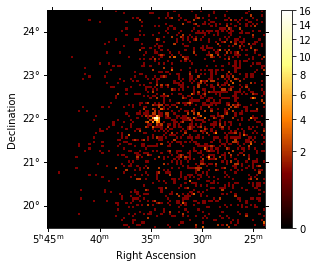

In [5]:
# get observation
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")
obs = data_store.get_observations([23592])[0]

# fill dataset
maker = MapDatasetMaker()
dataset = maker.run(dataset_empty, obs)
print(dataset)
dataset.counts.sum_over_axes().plot(stretch="sqrt", add_cbar=True);

The `MapDatasetMaker` fills the corresponding `counts`, `exposure`, `background`,
`psf` and `edisp` map per observation. The `MapDatasetMaker` has a
`selection` parameter, in case some of the maps should not be computed. There is also a `background_oversampling` parameter that defines the oversampling factor in energy used to compute the bakcground (default is None).

## Safe data range handling


To exclude the data range from a `MapDataset`, that is associated with
high systematics on instrument response functions, a `mask_safe`
can be defined. The `mask_safe` is a `Map` object with `bool` data
type, which indicates for each pixel, whether it should be included
in the analysis. The convention is that a value of `True` or `1`
includes the pixel, while a value of `False` or `0` excludes a pixels
from the analysis. To compute safe data range masks according to certain
criteria, Gammapy provides a `SafeMaskMaker` class. The different criteria are given by the `methods`argument, available options are :

- aeff-default, uses the energy ranged specified in the DL3 data files, if available.
- aeff-max, the lower energy threshold is determined such as the effective area is above a given percentage of its maximum
- edisp-bias, the lower energy threshold is determined such as the energy bias is below a given percentage
- offset-max, the data beyond a given offset radius from the observation center are excluded
- bkg-peak, the energy threshold is defined as the upper edge of the energy bin with the highest predicted background rate. This method was introduced in the HESS DL3 validation paper: https://arxiv.org/pdf/1910.08088.pdf



Multiple methods can be combined. Here is an example :


WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (100, 100, 11)
	ndim  : 3
	unit  : 
	dtype : bool



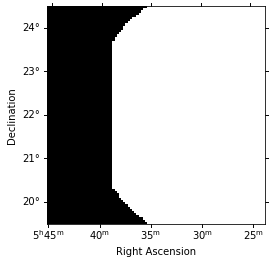

In [6]:
safe_mask_maker = SafeMaskMaker(
    methods=["aeff-default", "offset-max"], offset_max="3 deg"
)

dataset = maker.run(dataset_empty, obs)
dataset = safe_mask_maker.run(dataset, obs)
print(dataset.mask_safe)
dataset.mask_safe.sum_over_axes().plot();


The `SafeMaskMaker` does not modify any data, but only defines the
`MapDataset.mask_safe` attribute. This means that the safe data
range can be defined and modified in between the data reduction
and stacking and fitting. For a joint-likelihood analysis of multiple
observations the safe mask is applied to the counts and predicted
number of counts map during fitting. This correctly accounts for
contributions (spill-over) by the PSF from outside the field of view.

## Background estimation


The background computed by the `MapDatasetMaker` gives the number of counts predicted
by the background IRF of the observation. Because its actual normalization, or even its
spectral shape, might be poorly constrained, it is necessary to correct it with the data
themselves. This is the role of background estimation Makers. 


### FoV background


If the background energy dependent morphology is well reproduced by the background model
stored in the IRF, it might be that its normalization is incorrect and that some spectral
corrections are necessary. This is made possible thanks to the `~gammapy.makers.FoVBackgroundMaker`.
This technique is recommended in most 3D data reductions. For more details and usage, see [fov_background](https://docs.gammapy.org/dev/makers/fov.html).

Here we are going to use a `~gammapy.makers.FoVBackgroundMaker` that will rescale the background model to the data excluding the region where a known source is present. For more details on the way to create exclusion masks see the [mask maps](mask_maps.ipynb) notebook.


In [7]:
circle = CircleSkyRegion(center=geom.center_skydir, radius=0.2 * u.deg)
exclusion_mask = geom.region_mask([circle], inside=False)

fov_bkg_maker = FoVBackgroundMaker(
    method="scale", exclusion_mask=exclusion_mask
)
dataset = fov_bkg_maker.run(dataset)

Other backgrounds production methods are available as listed below.

### Ring background

If the background model does not reproduce well the morphology, a classical approach consists
in applying local corrections by smoothing the data with a ring kernel. This allows to build a set
of OFF counts taking into account the inperfect knowledge of the background. This is implemented
in the `~gammapy.makers.RingBackgroundMaker` which transforms the Dataset in a `MapDatasetOnOff`.
This technique is mostly used for imaging, and should not be applied for 3D modeling and fitting.

For more details and usage, see [ring_background](https://docs.gammapy.org/dev/makers/ring.html).


### Reflected regions background

In the absence of a solid background model, a classical technique in Cherenkov astronomy for 1D
spectral analysis is to estimate the background in a number of OFF regions. When the background
can be safely estimated as radially symmetric w.r.t. the pointing direction, one can apply the
reflected regions background technique.
This is implemented in the `~gammapy.makers.ReflectedRegionsBackgroundMaker` which transforms a
`SpectrumDataset` in a `SpectrumDatasetOnOff`. This technique is only used for 1D spectral
analysis.

For more details and usage, see [reflected_background](https://docs.gammapy.org/dev/makers/reflected.html).


## Data reduction loop

The data reduction steps can be combined in a single loop to run
a full data reduction chain. For this the `MapDatasetMaker` is run
first and the output dataset is the passed on to the next maker step.
Finally the dataset per observation is stacked into a larger map.

In [8]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")
observations = data_store.get_observations([23523, 23592, 23526, 23559])

energy_axis = MapAxis.from_bounds(
    1, 10, nbin=11, name="energy", unit="TeV", interp="log"
)
geom = WcsGeom.create(
    skydir=(83.63, 22.01), axes=[energy_axis], width=5, binsz=0.02
)

dataset_maker = MapDatasetMaker()
safe_mask_maker = SafeMaskMaker(
    methods=["aeff-default", "offset-max"], offset_max="3 deg"
)

stacked = MapDataset.create(geom)

for obs in observations:
    local_dataset = stacked.cutout(obs.pointing_radec, width="6 deg")
    dataset = dataset_maker.run(local_dataset, obs)
    dataset = safe_mask_maker.run(dataset, obs)
    dataset = fov_bkg_maker.run(dataset)
    stacked.stack(dataset)

print(stacked)

MapDataset
----------

  Name                            : WL4nuYzo 

  Total counts                    : 7972 
  Total background counts         : 7555.42
  Total excess counts             : 416.58

  Predicted counts                : 7555.42
  Predicted background counts     : 7555.42
  Predicted excess counts         : nan

  Exposure min                    : 1.04e+06 m2 s
  Exposure max                    : 3.22e+09 m2 s

  Number of total bins            : 687500 
  Number of fit bins              : 687214 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




To maintain good performance it is always recommended to do a cutout
of the `MapDataset` as shown above. In case you want to increase the
offset-cut later, you can also choose a larger width of the cutout
than `2 * offset_max`.

Note that we stack the individual `MapDataset`, which are computed
per observation into a larger dataset. During the stacking the safe data
range mask (`MapDataset.mask_safe`) is applied by setting data outside to
zero, then data is added to the larger map dataset. To stack multiple
observations, the larger dataset must be created first.

The data reduction loop shown above can be done throught the `DatasetsMaker` class that take as argument a list of makers. **Note that the order of the makers list is important as it determines their execution order.** Moreover the `stack_datasets` option offers the possibily to stack or not the output datasets, and the `n_jobs` option allow to use multiple processes on run.

In [9]:
global_dataset = MapDataset.create(geom)
makers = [dataset_maker, safe_mask_maker, fov_bkg_maker]  # the order matter
datasets_maker = DatasetsMaker(makers, stack_datasets=False, n_jobs=1)
datasets = datasets_maker.run(global_dataset, observations)
print(datasets)

Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : MZgyqHov
  Instrument : HESS
  Models     : ['MZgyqHov-bkg']

Dataset 1: 

  Type       : MapDataset
  Name       : bjUXJ36B
  Instrument : HESS
  Models     : ['bjUXJ36B-bkg']

Dataset 2: 

  Type       : MapDataset
  Name       : SCzupwVP
  Instrument : HESS
  Models     : ['SCzupwVP-bkg']

Dataset 3: 

  Type       : MapDataset
  Name       : FZoHivQp
  Instrument : HESS
  Models     : ['FZoHivQp-bkg']




## Spectrum dataset

The spectrum datasets represent 1D spectra along an energy axis whitin a given on region. The `SpectrumDataset` contains a counts spectrum, and a background model. The `SpectrumDatasetOnOff` contains ON and OFF count spectra, background is implicitly modeled via the OFF counts spectrum. 

The `SpectrumDatasetMaker` make spectrum dataset for a single observation.
In that case the irfs and background are computed at a single fixed offset, which is recommend only for point-sources.

Here is an example of data reduction loop to create `SpectrumDatasetOnOff` datasets:

In [10]:
# on region is given by the CircleSkyRegion previously defined
geom = RegionGeom.create(region=circle, axes=[energy_axis])
exclusion_mask_2d = exclusion_mask.reduce_over_axes(
    np.logical_or, keepdims=False
)

spectrum_dataset_empty = SpectrumDataset.create(
    geom=geom, energy_axis_true=energy_axis_true
)

spectrum_dataset_maker = SpectrumDatasetMaker(
    containment_correction=False, selection=["counts", "exposure", "edisp"]
)
reflected_bkg_maker = ReflectedRegionsBackgroundMaker(
    exclusion_mask=exclusion_mask_2d
)
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

datasets = Datasets()

for observation in observations:
    dataset = spectrum_dataset_maker.run(
        spectrum_dataset_empty.copy(name=f"obs-{observation.obs_id}"),
        observation,
    )
    dataset_on_off = reflected_bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    datasets.append(dataset_on_off)
print(datasets)

Datasets
--------

Dataset 0: 

  Type       : SpectrumDatasetOnOff
  Name       : obs-23523
  Instrument : HESS
  Models     : 

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : obs-23592
  Instrument : HESS
  Models     : 

Dataset 2: 

  Type       : SpectrumDatasetOnOff
  Name       : obs-23526
  Instrument : HESS
  Models     : 

Dataset 3: 

  Type       : SpectrumDatasetOnOff
  Name       : obs-23559
  Instrument : HESS
  Models     : 


